# Data Cleaning

---

## Objectives

* Evaluate missing data
* Clean data.

## Inputs

* outputs/datasets/collection/HousePrice.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned 

## Conclusions

* Data cleaning pipeline
* Drop 'BedroomAbvGr', '2ndFlrSF', 'LotFrontage', 'MasVnrArea'.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-analysis/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-analysis'

# Load Collected Data

Firstly we need to load the data we have been working with previously.

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/HousePrices.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


---

# Data Exploration

Lets check over the distribution and shape of missing data.

In [5]:
vars_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea']

In [6]:
from ydata_profiling import ProfileReport
if vars_missing_data:
    profile = ProfileReport(df=df[vars_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

The following code cell was taken from the Code Institute Chrunometer walktrhough project and provides the 2 correlation heatmaps + PPS charts.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Now we calcultate correlations and power predictive score.

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean   std  min  25%  50%    75%    max
ppscore  462.0  0.065  0.11  0.0  0.0  0.0  0.094  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



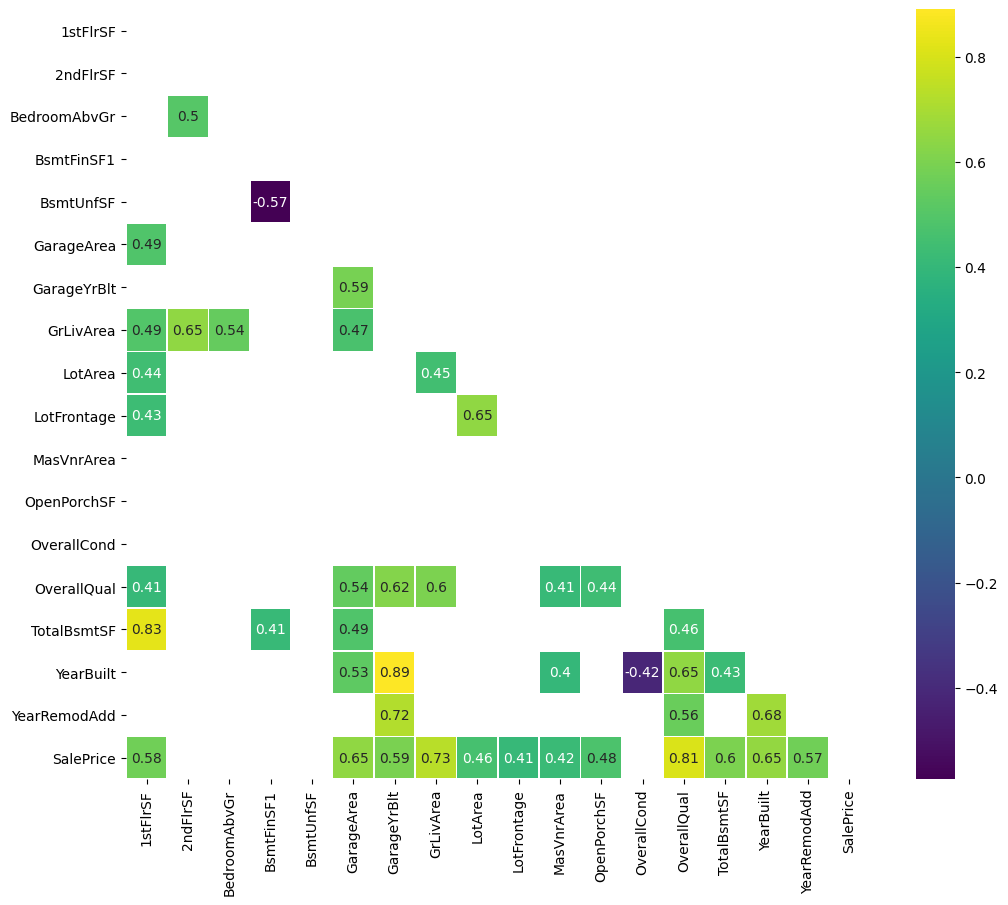



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



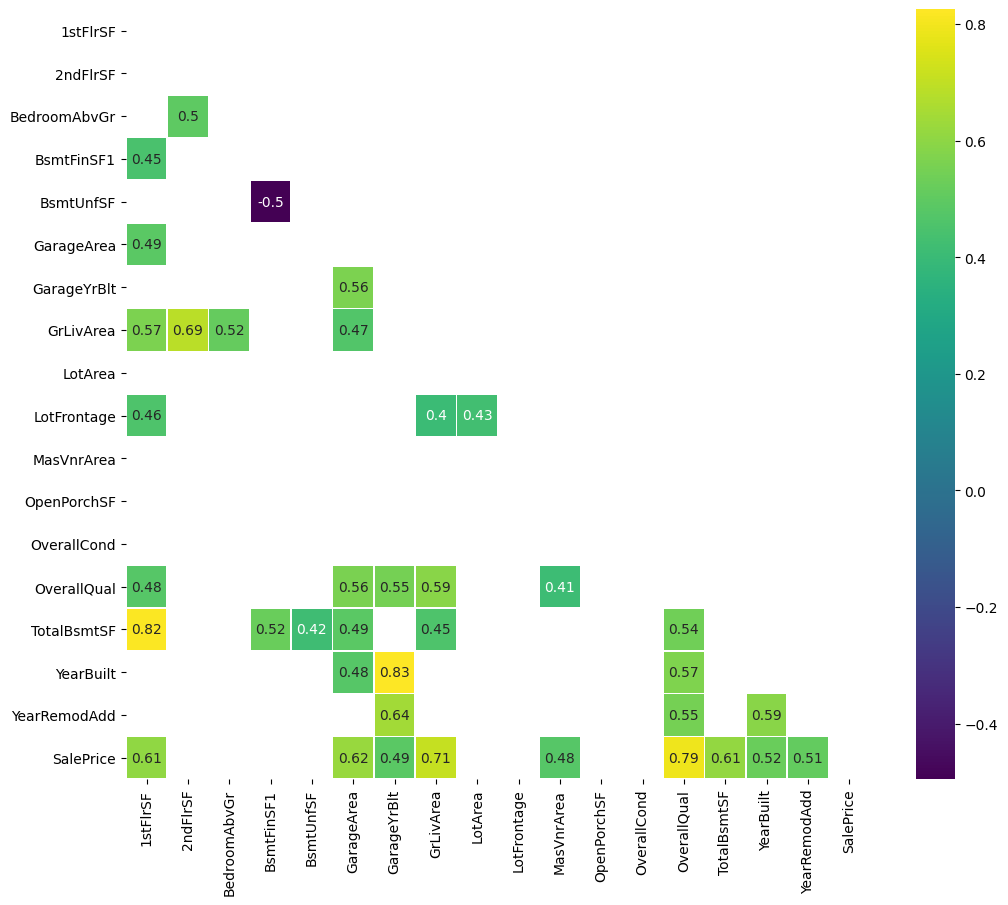



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



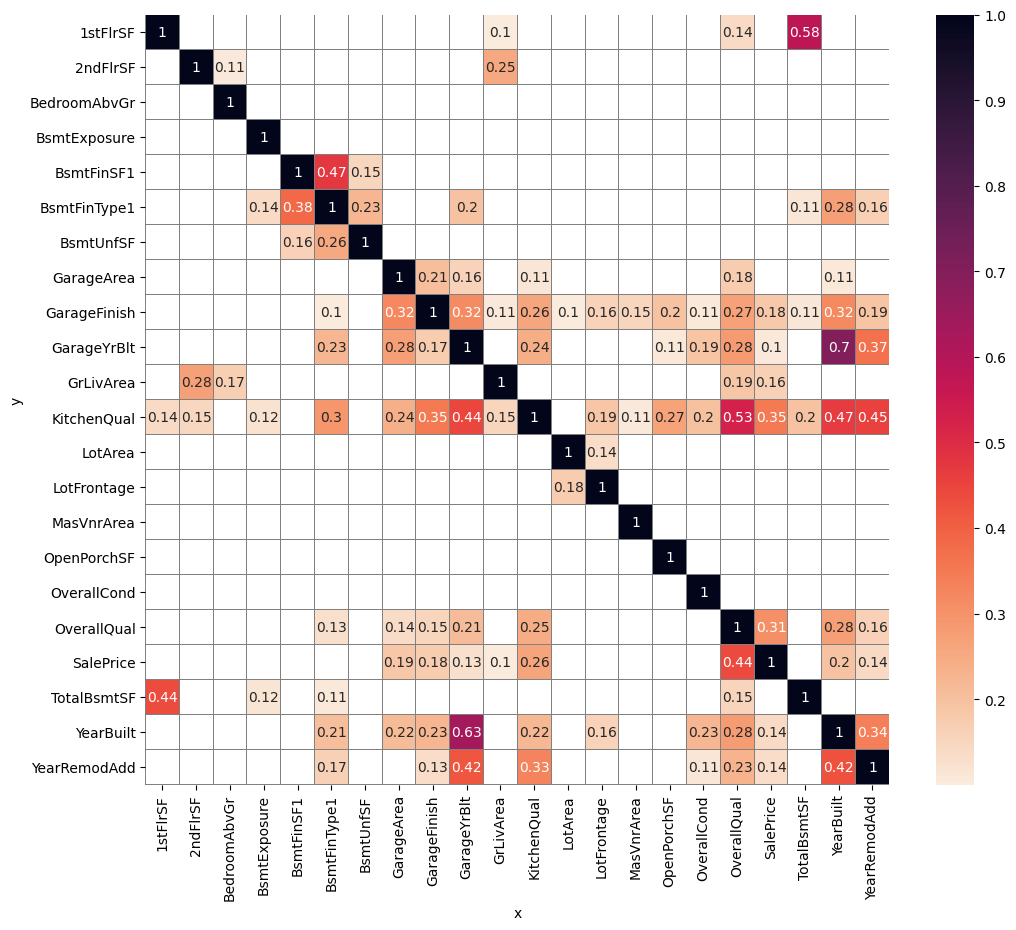

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.1,
                  figsize=(12,10), font_annot=10)

As we can see, most features have a low or medium correlation to each other. We can also see that the PPS score has a low or 0 PPS score almost across the board with only a handful of exceptions. This means that any predictions made would have sizable margin of error. In an ideal scenario we would either ask for more data or see if there's any other vbariables not contained in this data that might help with the prediction. However the client deems these scores acceptable, so we shall continue forward.

---

# Data Cleaning

## Assessing Missing Data Levels

A custom function (from Code Institute Churnometer project walkthrough) will be used to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [7]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


After Checking the PPS and correlations on all the data with missing entries, we have decided the following:

* Drop LotFrontage no PPS and low correlation score + fair bit of missing data.
* GarageFinish has no correlation score + fair bit of missing data, but has quite a few different values with some PPS.
* BsmtFinType1 has no correlation score + fair bit of missing data, but has quite a few different values with some PPS.
* Drop BedroomAbvGr no almost PPS or correlation score.
* Drop 2ndFlrSF low PPS and correlation score.
* Drop MasVnrArea no PPS and low correlation score.
* GarageYrBlt has a Fairly high PPS, correlation score and isn't missing too much data so we will keep this and will use a mean/median inputer to fill in the missing data.

## Drop Data

Now that we have transformed GarageYrBlt, we can look into dropping all the other features that were mentioned above. If we find results are not close to desirable then we will come back to this step and look to drop only the specific entries that contain missing data.

In [8]:
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline

In [9]:
pipeline = Pipeline([
      ( 'drop_features', DropFeatures(features_to_drop = ['LotFrontage', 'BedroomAbvGr', 'MasVnrArea', '2ndFlrSF']) )
])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,1stFlrSF,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,No,706,GLQ,150,548,RFn,2003.0,1710,Gd,8450,61,5,7,856,2003,2003,208500
1,1262,Gd,978,ALQ,284,460,RFn,1976.0,1262,TA,9600,0,8,6,1262,1976,1976,181500
2,920,Mn,486,GLQ,434,608,RFn,2001.0,1786,Gd,11250,42,5,7,920,2001,2002,223500
3,961,No,216,ALQ,540,642,Unf,1998.0,1717,Gd,9550,35,5,7,756,1915,1970,140000
4,1145,Av,655,GLQ,490,836,RFn,2000.0,2198,Gd,14260,84,5,8,1145,2000,2000,250000


## Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_transformed,
                                        df_transformed['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)
print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 18) 
TestSet shape: (292, 18)


---

## Mean Median Imputer

Lets deal with GarageYrBlt. We'll need to check if the mean or the median is more suitable first.

In [11]:
from feature_engine.imputation import MeanMedianImputer

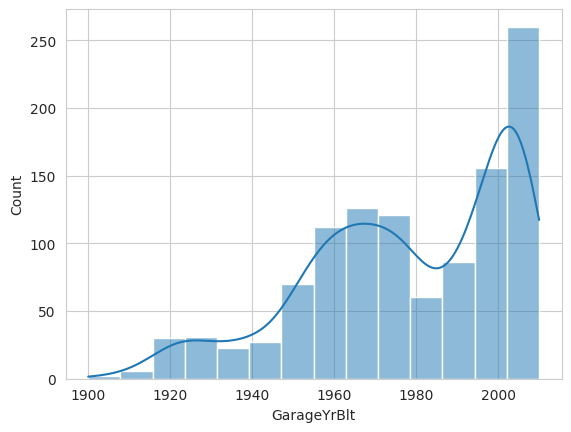

In [12]:
sns.set_style('whitegrid')
for col in ['GarageYrBlt']:
  sns.histplot(data=TrainSet, x=col, kde=True)
  plt.show()
  print('\n')

As this doesn't have anything like a bell curve shape we will use a median value instead of a mean value.

In [13]:
imputer = MeanMedianImputer(imputation_method='median',
                            variables=['GarageYrBlt'])

In [14]:
imputer.fit(TrainSet)

MeanMedianImputer(variables=['GarageYrBlt'])

In [15]:
TrainSet = imputer.transform(TrainSet)
print(type(TrainSet))
TrainSet.head()

<class 'pandas.core.frame.DataFrame'>


,1stFlrSF,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,Av,48,NaN,1774,774,Unf,2007.0,1828,Gd,11694,108,5,9,1822,2007,2007,314813
870,894,No,0,Unf,894,308,NaN,1962.0,894,TA,6600,0,5,5,894,1962,1962,109500
92,964,No,713,ALQ,163,432,Unf,1921.0,964,TA,13360,0,7,5,876,1921,2006,163500
817,1689,No,1218,GLQ,350,857,RFn,2002.0,1689,Gd,13265,59,5,8,1568,2002,2002,271000
302,1541,No,0,Unf,1541,843,RFn,2001.0,1541,Gd,13704,81,5,7,1541,2001,2002,205000


In [16]:
TrainSet.isnull().sum()

1stFlrSF          0
BsmtExposure      0
BsmtFinSF1        0
BsmtFinType1     89
BsmtUnfSF         0
GarageArea        0
GarageFinish    131
GarageYrBlt       0
GrLivArea         0
KitchenQual       0
LotArea           0
OpenPorchSF       0
OverallCond       0
OverallQual       0
TotalBsmtSF       0
YearBuilt         0
YearRemodAdd      0
SalePrice         0
dtype: int64

And now the same with the test set.

In [21]:
imputer = MeanMedianImputer(imputation_method='median',
                            variables=['GarageYrBlt'])

In [22]:
imputer.fit(TestSet)

MeanMedianImputer(variables=['GarageYrBlt'])

In [23]:
TestSet = imputer.transform(TestSet)
print(type(TestSet))
TestSet.head()

<class 'pandas.core.frame.DataFrame'>


,1stFlrSF,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
529,2515,No,1219,Rec,816,484,NaN,1975.0,2515,TA,32668,0,3,6,2035,1957,1975,200624
491,958,No,403,BLQ,238,240,Unf,1941.0,1578,Fa,9490,0,7,6,806,1941,1950,133000
459,979,No,185,LwQ,524,352,Unf,1950.0,1203,Gd,7015,0,4,5,709,1950,1950,110000
279,1156,No,392,BLQ,768,505,Fin,1977.0,2022,TA,10005,117,5,7,1160,1977,1977,192000
655,525,No,0,Unf,525,264,Unf,1971.0,1092,TA,1680,0,5,6,525,1971,1971,88000


In [25]:
TestSet.isnull().sum()

1stFlrSF         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1    25
BsmtUnfSF        0
GarageArea       0
GarageFinish    31
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
YearBuilt        0
YearRemodAdd     0
SalePrice        0
dtype: int64

## Categorical Imputer

As the relative amount of missing data for our categorical features is quite low, we will replace the missing data with the most frequent.

In [17]:
from feature_engine.imputation import CategoricalImputer
pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                  variables=['BsmtFinType1', 'GarageFinish']) )
])


TrainSet = pipeline.fit_transform(TrainSet)

In [18]:
TrainSet.isnull().sum()

1stFlrSF        0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

And again to the test set.

In [27]:
TestSet = pipeline.fit_transform(TestSet)

In [28]:
TestSet.isnull().sum()

1stFlrSF        0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

---

# Push Files to Repo

In [30]:
import os
try:
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print (e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


In [31]:
# Train set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

#Test set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)